# Kaggle notebook for laptop producers classification with TF

### Accelerator - GPU

A default cell so as to watch over the input data and import default modules.

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Here we've hardcoded pathes for train and test folders

In [6]:
laptop_folder_path = '/kaggle/input/laptops/laptop-images/laptop-images/'
test_laptop_folder_path = '/kaggle/input/laptops/test-laptop-images/test-laptop-images/'

We also need class names (according to the folder names) in future 

In [7]:
class_names = os.listdir(laptop_folder_path)
class_names.sort()

We need to plot the number of images we've got for the producers. Using os module we can count the number of images for each class (producer)

In [8]:
def get_dict_of_number_laptops(base_folder):
    dict_of_producers = {}
    for producer in os.listdir(base_folder):
        dict_of_producers[producer] = len(os.listdir(os.path.join(base_folder, producer)))
    return dict_of_producers

Here we use our function <i>get_dict_of_number_laptops(base_folder)</i> so as to get a dictionary, where a key is a producer name, and value - a number of laptop images

In [9]:
laptop_bars = get_dict_of_number_laptops(laptop_folder_path)

We need matplotlib for plotting (as a bar, like histogram) counted images

In [10]:
import matplotlib.pyplot as plt

Matplotlib bar doesn't (checked on 24.08.2020) support dufferent colours for different bars, so we need a list of different colours to use for different bars, as its been said before

In [11]:
def get_list_of_random_colors(num):
    return ['red','green','blue','yellow','orange','brown', 'magenta','purple'][:num]

Also the number of classes is important and will be used both in plotting and **tensorflow** model building

In [12]:
num_of_classes = len(laptop_bars.keys())

As a result we've calculated all the data we need for plotting the numbers of images of different classes.[](http://)

<BarContainer object of 8 artists>

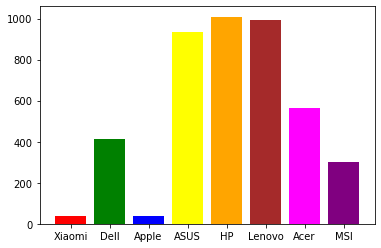

In [13]:
plt.bar(laptop_bars.keys(), laptop_bars.values(), color=get_list_of_random_colors(num_of_classes))

The 2 strongest computer vision modules. TF for model building and learning NN, cv2 for image preprocessing

In [14]:
import tensorflow as tf
import cv2

In [15]:
single_img_folder = os.path.join(laptop_folder_path, list(laptop_bars.keys())[0])
single_image_path = os.listdir(single_img_folder)[0]

laptop_img_shape = cv2.imread(os.path.join(single_img_folder, single_image_path)).shape
laptop_img_size = laptop_img_shape[:2]
print('image shape =', laptop_img_shape)
print('image size =', laptop_img_size)

image shape = (122, 174, 3)
image size = (122, 174)


So as to generate more data than we have, it's defineitly recommended to use *ImageDataGenerator()* obj from **tf.keras.preprocessing.image**.

 In the ImageDataGenerator we use arguments such as 
* rescale - for data scaling and speeding up the training, 
* zoom/shear for randomly generating new images (laptops are steel the laptops even with shear/zoom of 0.2), 
* the same for brightness - laptops are still the laptops even darker/brighter, 
* rotation. 
* Validation argument is used as we've got no valid data, so we ask keras to split the data for us.

In [16]:
laptop_imagegen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  brightness_range=(0,0.5),
                                                                  rotation_range=15,
                                                                  validation_split=0.15)
train_flow = laptop_imagegen.flow_from_directory(laptop_folder_path,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 target_size=laptop_img_size,
                                                 subset='training')
valid_flow = laptop_imagegen.flow_from_directory(laptop_folder_path,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 target_size=laptop_img_size,
                                                 subset='validation')

Found 3652 images belonging to 8 classes.
Found 638 images belonging to 8 classes.


As the images of laptops are very complex and include a lot of useful features such as labels, keyboard style, unusual shapes, body shapes etc. CNN is a very successful solution for images like we've got. Also we'll use Dropout layers so as to prevent overfitting too (as we said in the previous cell, using *ImageDataGenerator()* with multiple right arguments quite well prevents overfitting).

As an optimizer for learning (backprop) Adam has been picked, fixes problems of gradient descent, as it's the most common optimizer for such problems like we've got.

classic loss for categorical classes - *categorical_crossentropy*


In [17]:
laptop_producer_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', 
                                                                           input_shape=laptop_img_shape),
                                                   tf.keras.layers.MaxPooling2D(2, 2),
                                                   tf.keras.layers.Dropout(0.3),
                                                   tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
                                                   tf.keras.layers.MaxPooling2D(2, 2),
                                                   tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
                                                   tf.keras.layers.MaxPooling2D(2, 2),
                                                   tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
                                                   tf.keras.layers.MaxPooling2D(2, 2),                                         
                                                   tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
                                                   tf.keras.layers.MaxPooling2D(2, 2),
                                                   tf.keras.layers.Flatten(),
                                                   tf.keras.layers.Dense(128, activation='relu'),
                                                   tf.keras.layers.Dense(num_of_classes, activation='softmax')])

laptop_producer_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

laptop_producer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 170, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 83, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 19, 64)        0

In [18]:
laptop_fit_hist = laptop_producer_model.fit(train_flow, epochs=10, validation_data=valid_flow, verbose=1)

Epoch 1/10
115/115 [==============================] - 57s 494ms/step - loss: 1.6387 - accuracy: 0.3803 - val_loss: 1.4255 - val_accuracy: 0.5361
Epoch 2/10
115/115 [==============================] - 39s 339ms/step - loss: 1.1422 - accuracy: 0.6336 - val_loss: 0.9321 - val_accuracy: 0.6897
Epoch 3/10
115/115 [==============================] - 39s 341ms/step - loss: 0.7753 - accuracy: 0.7484 - val_loss: 0.6517 - val_accuracy: 0.8135
Epoch 4/10
115/115 [==============================] - 39s 339ms/step - loss: 0.5929 - accuracy: 0.8201 - val_loss: 0.5403 - val_accuracy: 0.8448
Epoch 5/10
115/115 [==============================] - 40s 343ms/step - loss: 0.5086 - accuracy: 0.8494 - val_loss: 0.5060 - val_accuracy: 0.8558
Epoch 6/10
115/115 [==============================] - 38s 329ms/step - loss: 0.3752 - accuracy: 0.8842 - val_loss: 0.3837 - val_accuracy: 0.8966
Epoch 7/10
115/115 [==============================] - 38s 332ms/step - loss: 0.3392 - accuracy: 0.8943 - val_loss: 0.3115 - val_ac

For watching the plot of accuracy and validation accuracy, we need to plot the history of our learning.

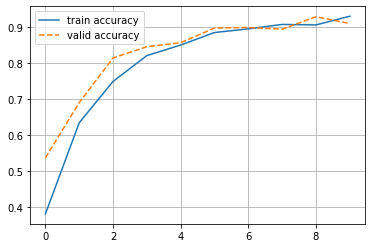

In [19]:
plt.plot(range(len(laptop_fit_hist.history['accuracy'])), laptop_fit_hist.history['accuracy'], label='train accuracy')
plt.plot(range(len(laptop_fit_hist.history['val_accuracy'])), laptop_fit_hist.history['val_accuracy'], '--', label='valid accuracy')
plt.grid(True)
plt.legend()

Self-written function get_producer_prediction_class_name_for(img_array). It takes a numpy matrix of N by 1 shape where each element represents the probability that an image belongs to some class **(according to the index, class names are sorted by default!)** 

In [20]:
def get_producer_prediction_class_name_for(img_array):
    prediction = laptop_producer_model.predict(img_array)[0]
    max_val = -1
    max_indx = -1
    for indx, prob in enumerate(prediction):
        if prob > max_val:
            max_val = prob
            max_indx = indx
    return class_names[max_indx]

Here we can take test folder and try to use the model we've trained. In the end we'll try to plot some images and the prediction class.

In [21]:
real_producers = []
images_for_show = []
prediction_producers = []

for producer_fold in os.listdir(test_laptop_folder_path):
    cur_full_test_path = os.path.join(test_laptop_folder_path, producer_fold)
    for image in os.listdir(cur_full_test_path):
        full_img_path = os.path.join(cur_full_test_path, image)
        real_producers.append(producer_fold)
        image = tf.keras.preprocessing.image.load_img(full_img_path, target_size=laptop_img_size)
        image = tf.keras.preprocessing.image.img_to_array(image)    
        images_for_show.append(cv2.resize(cv2.imread(full_img_path),laptop_img_size))
        image = np.expand_dims(image, axis=0)
        prediction_producers.append(get_producer_prediction_class_name_for(image))

assert len(real_producers) == len(images_for_show) == len(prediction_producers)

selected images indeces: {1442, 3014, 1575, 3752, 1194, 1035, 755, 2967, 2137, 444}


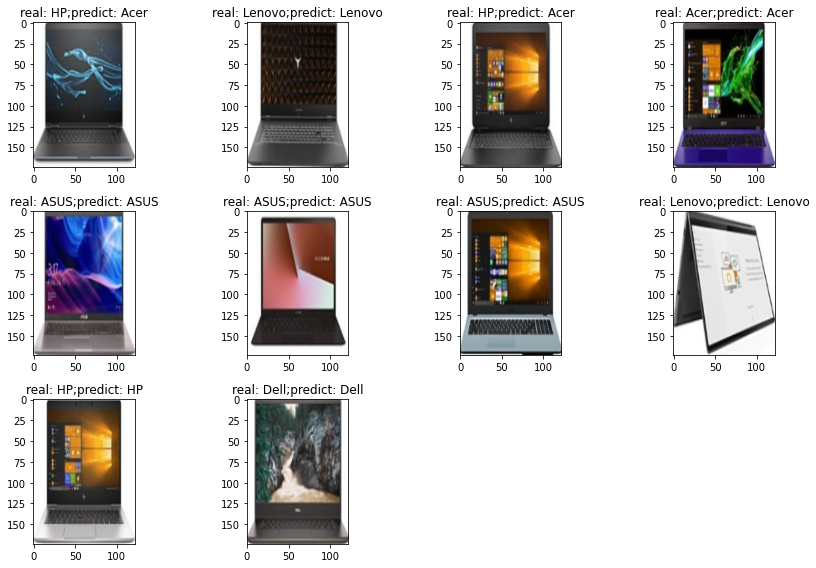

In [35]:
num_of_test_images = len(real_producers)
max_num_of_examples = 10
#set so as to avoid similar images to show
random_indeces = set([np.random.randint(0, len(real_producers)) for _ in range(max_num_of_examples)])
print('selected images indeces:',random_indeces)
example_fig = plt.figure(figsize=(12, 8))
for indx, img_indx in enumerate(random_indeces):
    plt.subplot(3, 4, indx + 1)
    plt.imshow(images_for_show[img_indx])
    plt.title('real: ' + real_producers[img_indx] + ';predict: ' + prediction_producers[img_indx])
plt.tight_layout()